<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

import random

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [170]:
# ANSWER
data = pd.read_csv('E:/IOD_data/titanic.csv', index_col = 'PassengerId')

In [171]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [172]:
data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [27]:
# ANSWER
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [28]:
# cabin is useless, setting to 0
data.loc[:,'Cabin'] = 0
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,0,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,0,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,0,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,0,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,0,S


In [29]:
# taking the mean age to fill in the null values
female_mean_age = data[data['Sex'] == 'female']['Age'].mean()
male_mean_age = data[data['Sex'] == 'male']['Age'].mean()

female_index = data.loc[(data['Age'].isnull()) & (data['Sex'] == 'female')]['Age'].index
male_index = data.loc[(data['Age'].isnull()) & (data['Sex'] == 'male')]['Age'].index

female_index = female_index - 1
male_index = male_index - 1


for i in female_index:
    data.iloc[i,4] = female_mean_age

    
for i in male_index:
    data.iloc[i,4] = male_mean_age

In [30]:
data[data['Sex'] == 'female'].isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    2
dtype: int64

In [31]:
# fill missing embarked values with random values
embarked_list = ['C', 'Q', 'S']
missing_embarked = data[data['Embarked'].isnull()]
missing_embarked_index = missing_embarked.index - 1

for i in missing_embarked_index:
    print(i)
    data.iloc[i,10] = random.choice(embarked_list)
    print(data.iloc[61,10])




61
C
829
C


In [50]:
#recheck
data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [74]:
# ANSWER
X = data[['Pclass','Parch']]

In [75]:
y = data['Survived']
y = y.reset_index()
y = y['Survived']
y = y.to_numpy()

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [77]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [78]:
# ANSWER
# Create Model
clf = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [79]:
# ANSWER
# Fit Model
clf.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [80]:
# ANSWER
clf.coef_

array([[-0.88528877,  0.37910902]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [81]:
# ANSWER
clf.intercept_

array([1.32709322])

We can create tuples of the predictor names and coefficients like this:

In [58]:
# ANSWER
print(set(zip(X, clf.coef_[0])))

NameError: name 'feature_cols' is not defined

If we want formatted output, here is a neat way to list the coefficients by predictor:

In [59]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

NameError: name 'model' is not defined

This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [82]:
# ANSWER
clf.score(X_train, y_train)

0.6912751677852349

What is the  `accuracy_score` for the test data?

In [83]:
# ANSWER
clf.score(X_test, y_test)

0.6711864406779661

What can we say aout this result?

ANSWER
- ...
- ...

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [ ]:
# ANSWER
# have already done this in the EDA copying and pasting code here
# running it will produce no output has all NA values are gone

# taking the mean age to fill in the null values
female_mean_age = data[data['Sex'] == 'female']['Age'].mean()
male_mean_age = data[data['Sex'] == 'male']['Age'].mean()

female_index = data.loc[(data['Age'].isnull()) & (data['Sex'] == 'female')]['Age'].index
male_index = data.loc[(data['Age'].isnull()) & (data['Sex'] == 'male')]['Age'].index

female_index = female_index - 1
male_index = male_index - 1


for i in female_index:
    data.iloc[i,4] = female_mean_age

    
for i in male_index:
    data.iloc[i,4] = male_mean_age


In [84]:
# Build Model
X = data[['Pclass','Parch','Age']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state = 1)
# Fit Model
clf.fit(X_train,y_train)
# Score
clf.score(X_train, y_train)

0.7181208053691275

So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

Age helped improve the score, which in this case was the max. likelihood by 0.04. Small increase may indicate that the Age feature is does not contribute much in terms ofadding to the probability that a person survived

Let's see where the model is going wrong by showing the Confusion Matrix:

In [85]:
# ANSWER
y_pred_class = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred_class))

[[141  33]
 [ 63  58]]


Nb. Here is how `confusion_matrix` arranges its output:

In [ ]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

Which type of error is more prevalent?

ANSWER: False negative, Type 2 error

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

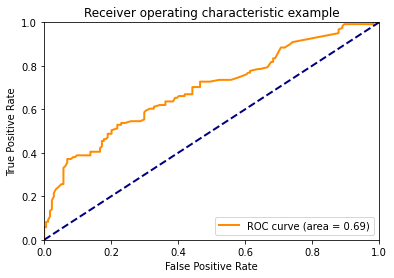

In [86]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = clf.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [41]:
titanic_with_dummies = pd.get_dummies(data = data, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [42]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

In [44]:
titanic_with_dummies

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.000000,1,0,A/5 21171,7.2500,0,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.000000,1,0,PC 17599,71.2833,0,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.000000,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000000,1,0,113803,53.1000,0,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.000000,0,0,373450,8.0500,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,"Montvila, Rev. Juozas",27.000000,0,0,211536,13.0000,0,0,1,0,0,1,0,1,0
888,1,"Graham, Miss. Margaret Edith",19.000000,0,0,112053,30.0000,0,1,0,0,0,1,1,0,0
889,0,"Johnston, Miss. Catherine Helen ""Carrie""",27.915709,1,2,W./C. 6607,23.4500,0,1,0,0,0,1,0,0,1


Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [94]:
# ANSWER
# Set Feature Both Numerical, Categorical
X = titanic_with_dummies[['Pclass_1', 'Pclass_2','Pclass_3','Parch', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f'TN : {cm[0][0]}')
print(f'FP : {cm[0][1]}')
print(f'FN : {cm[1][0]}')
print(f'TP : {cm[1][1]}')



TN : 145
FP : 29
FN : 43
TP : 78


Plot the ROC curve for the new model:

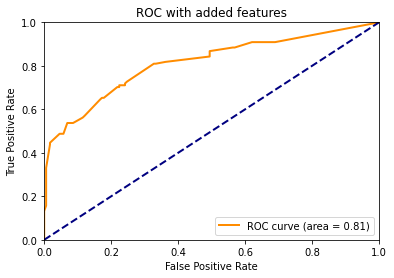

In [95]:
# ANSWER
y_pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with added features')
plt.legend(loc = "lower right")
plt.show()


Can we improve the model by including the remaining features?

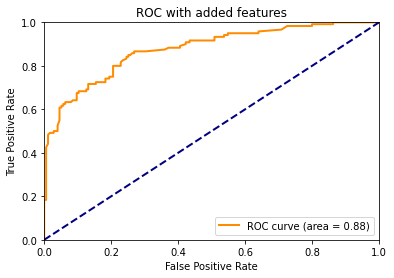

In [149]:
# adding in fare and Sibsp, leaving cabin as all is 0 and ticket number as format of values are all over of the place
X = titanic_with_dummies[['Pclass_1', 'Pclass_2','Pclass_3','Parch', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male','Fare','SibSp']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33)
clf.fit(X_train, y_train)

y_pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with added features')
plt.legend(loc = "lower right")
plt.show()


Model only improves by 0.01 by adding SibSp and Fare, indicating that it cannot be improved any further

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

1. Yes results will change

In [150]:
# fpr and tpr vectors for best model
fpr

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00571429, 0.00571429, 0.00571429, 0.00571429, 0.00571429,
       0.00571429, 0.00571429, 0.01142857, 0.01142857, 0.01714286,
       0.02857143, 0.02857143, 0.04      , 0.04      , 0.04571429,
       0.04571429, 0.05142857, 0.05142857, 0.05714286, 0.05714286,
       0.06285714, 0.06285714, 0.06857143, 0.08      , 0.08571429,
       0.09714286, 0.09714286, 0.10285714, 0.10285714, 0.12571429,
       0.12571429, 0.13142857, 0.13142857, 0.13142857, 0.15428571,
       0.15428571, 0.16571429, 0.17714286, 0.18285714, 0.18285714,
       0.19428571, 0.19428571, 0.20571429, 0.20571429, 0.22857143,
       0.22857143, 0.23428571, 0.24571429, 0.24571429, 0.25142857,
       0.25142857, 0.25714286, 0.26285714, 0.26857143, 0.26857143,
       0.28      , 0.30285714, 0.36      , 0.37142857, 0.38857143,
       0.40571429, 0.40571429, 0.42285714, 0.42285714, 0.43428571,
       0.43428571, 0.44571429, 0.47428571, 0.50857143, 0.50857

In [151]:
# fpr and tpr vectors for best model
tpr

array([0.        , 0.00833333, 0.15833333, 0.175     , 0.18333333,
       0.18333333, 0.26666667, 0.28333333, 0.35      , 0.36666667,
       0.38333333, 0.425     , 0.44166667, 0.48333333, 0.49166667,
       0.49166667, 0.5       , 0.5       , 0.525     , 0.55      ,
       0.60833333, 0.60833333, 0.61666667, 0.61666667, 0.625     ,
       0.625     , 0.63333333, 0.63333333, 0.63333333, 0.64166667,
       0.64166667, 0.675     , 0.675     , 0.68333333, 0.68333333,
       0.69166667, 0.69166667, 0.70833333, 0.71666667, 0.71666667,
       0.725     , 0.725     , 0.725     , 0.725     , 0.74166667,
       0.74166667, 0.75      , 0.75      , 0.8       , 0.8       ,
       0.81666667, 0.825     , 0.83333333, 0.84166667, 0.84166667,
       0.85      , 0.85      , 0.85833333, 0.85833333, 0.86666667,
       0.86666667, 0.86666667, 0.875     , 0.88333333, 0.88333333,
       0.88333333, 0.89166667, 0.9       , 0.90833333, 0.90833333,
       0.91666667, 0.91666667, 0.91666667, 0.91666667, 0.93333

In [164]:
# using Logistic CV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV

X = titanic_with_dummies[['Pclass_1', 'Pclass_2','Pclass_3','Parch', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male','Fare','SibSp']]
clf_cv = LogisticRegressionCV(cv=5, random_state = 1, max_iter = 400)
clf_cv.fit(X, y)

y_pred_cv = clf_cv.predict(X)

accuracy_cv = accuracy_score(y, y_pred_cv)
accuracy_cv



0.7968574635241302

In [169]:
# normal train test split
X = titanic_with_dummies[['Pclass_1', 'Pclass_2','Pclass_3','Parch', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male','Fare','SibSp']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 1)
clf = LogisticRegression(max_iter = 400)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_base = accuracy_score(y_test, y_pred)
accuracy_base

0.7593220338983051

As it can be seen above, using CV logistic regression increases accuracy by 0.04



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



